In [354]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import itertools

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix

N_FOLDS = 5
RANDOM_STATE = 69
# file_name = os.path.basename(__file__).split('.')[0]
sns.set(style='white', context='notebook', palette='deep')

In [465]:
data = pd.read_csv('../Data/TestParam.csv')
data.shape

(42000, 785)

In [466]:
data.head()

,label,param0,param1,param2,param3,param4,param5,param6,param7,param8,...,param774,param775,param776,param777,param778,param779,param780,param781,param782,param783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [467]:
# check if any null value in our data
data.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

<H2>Visualizing the labels</H2>

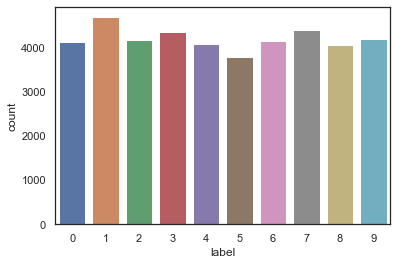

In [468]:
# data.shape returns (42000,785)
# predict label for test data
target = data['label']
sns.countplot(target)

In [469]:
# get numpy arrays
X = data.drop('label', axis=1)
del data  # to free up the memory

In [470]:
X.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [471]:
# startify is used to avoid underrepresentation of any class even by chance
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.20, random_state=RANDOM_STATE, stratify=target)

In [472]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}\nX_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (33600, 784), y_train shape: (33600,)
X_test shape: (8400, 784), y_test shape: (8400,)


In [477]:
# # train = pd.concat([X_train, y_train], axis=1)
# test = pd.concat([X_test, y_test], axis=1)
# print(f"test: {test.shape}")

## Normalize data

In [478]:
# not needed
# Normalize the data for faster CNN computations
X_train = X_train / 255.0
X_test = X_test / 255.0

## Reshaping to get image (28x28x1) 1-channel

In [479]:
X_train = X_train.values.reshape(-1,28,28,1)

In [480]:
X_test = X_test.values.reshape(-1,28,28,1)

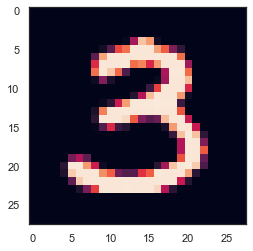

In [481]:
plt.imshow(X_train[1][:,:,0])

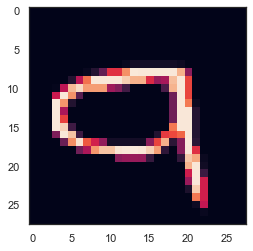

In [482]:
plt.imshow(X_test[1][:,:,0])

## Encoding labels

In [483]:
from keras.utils import to_categorical 
y_train = to_categorical(y_train, num_classes = 10)

In [484]:
# Encoding using scikit learn

# ohe = OneHotEncoder()
# ohe.fit_transform(y_test.values.reshape(-1,1))

### Getting training and validation test (Use part of Training set for Validation purposes)

In [485]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=RANDOM_STATE, stratify=y_train)

In [371]:
print(X_train.shape, X_val.shape)

(30240, 28, 28, 1) (3360, 28, 28, 1)


## Create Keras Model 

In [372]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, experimental
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

## Avoiding overfitting by Data Augmentation
<H6> When trained with Data Augmentation, accuracy curves are going very smoothly upwards, in comparison to without Data Augmentation Training 

In [373]:
data_augmentation = Sequential([
    experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical', input_shape=(28, 28, 1)),
    experimental.preprocessing.RandomRotation(factor=0.3),
    experimental.preprocessing.RandomContrast(0.1),
    experimental.preprocessing.RandomZoom(0.1),
], name="data_augmentation")

In [279]:
# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.1, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=False,  # randomly flip images
#         vertical_flip=False)  # randomly flip images


# datagen.fit(X_train)

- epochs defined in a cell below tensorboard <br>
- callbacks

In [298]:
# history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=64),
#                               epochs = epochs, validation_data = (X_val,y_val),
#                               verbose = 2, steps_per_epoch=X_train.shape[0] // 64
#                               , callbacks=callbacks)

Epoch 1/30


/opt/anaconda3/envs/python_37/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


TypeError: 'NoneType' object is not callable

In [374]:
# designing the model

model = Sequential([
    data_augmentation,
    Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu', input_shape = (28,28,1)),
    BatchNormalization(axis = 1),
    MaxPool2D(),
    
    Conv2D(64, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(axis = 1),
    MaxPool2D(),
    
    Conv2D(128, 3, padding = 'same', activation='relu'),
    BatchNormalization(axis = 1),
    MaxPool2D(),
    
    Conv2D(128, 3, padding = 'same', activation='relu'),
    BatchNormalization(axis = 1),
#     MaxPool2D(strides=(2,2)),
    MaxPool2D(),
    
    Dropout(0.2),
    Flatten(),
    Dense(256, activation = 'relu'),
    Dense(10, activation = "softmax"),
])

In [375]:
model.compile(
            optimizer=Adam(1e-3),  #lr=0.0001
            # optimizer='adam',
            loss=CategoricalCrossentropy(from_logits=True),
            # loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

In [376]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 32)        112       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 64)        56        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 64)         

## Setup tensorboard

In [323]:
import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

## Use `logdir` to logs folder to regenerate the plots in tensorboard

In [324]:
%load_ext tensorboard
%tensorboard --logdir=logs/ --host localhost --port 8088

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [327]:
# remove old logs
# !rm -rf ./logs/

In [377]:
# configuring model

epochs=30
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    ModelCheckpoint("model_chkpts/save_at_{epoch}.h5"),
    TensorBoard(logdir, histogram_freq=1),
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1, mode='auto'
    )
]

In [378]:
# start fitting the model

history=model.fit(X_train,
                  y_train,
                  validation_data=(X_val, y_val),
                  epochs=epochs,
                  callbacks=callbacks)

Epoch 1/30
945/945 [==============================] - 63s 66ms/step - loss: 1.3174 - accuracy: 0.5438 - val_loss: 0.4912 - val_accuracy: 0.8372
Epoch 2/30
945/945 [==============================] - 109s 115ms/step - loss: 0.4233 - accuracy: 0.8634 - val_loss: 0.3939 - val_accuracy: 0.8765
Epoch 3/30
945/945 [==============================] - 85s 90ms/step - loss: 0.3294 - accuracy: 0.8923 - val_loss: 0.3358 - val_accuracy: 0.8851
Epoch 4/30
945/945 [==============================] - 89s 94ms/step - loss: 0.2857 - accuracy: 0.9078 - val_loss: 0.2993 - val_accuracy: 0.9036
Epoch 5/30
945/945 [==============================] - 91s 96ms/step - loss: 0.2523 - accuracy: 0.9187 - val_loss: 0.2760 - val_accuracy: 0.9140
Epoch 6/30
945/945 [==============================] - 83s 88ms/step - loss: 0.2334 - accuracy: 0.9201 - val_loss: 0.2545 - val_accuracy: 0.9152
Epoch 7/30
945/945 [==============================] - 82s 87ms/step - loss: 0.2264 - accuracy: 0.9267 - val_loss: 0.1820 - val_accurac

### Tensorboard already draws the following plots
> Training and Validation Accuracy/Loss

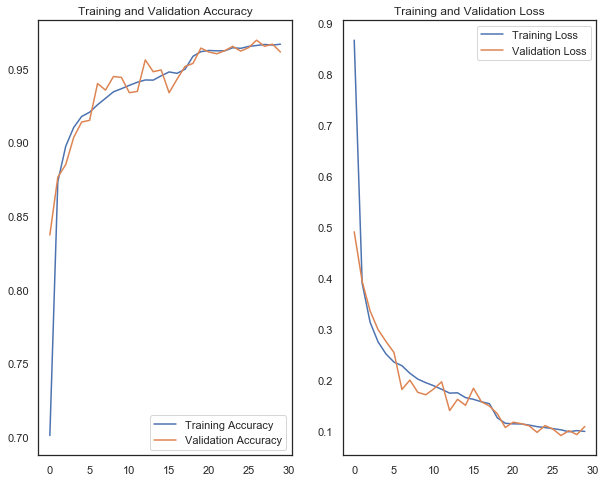

In [379]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Loading saved model at 30th Epoch
- Trained on without Data Augmentation

In [387]:
from keras.models import load_model
model = load_model('model_chkpts1/save_at_30.h5')  # model under model_chkpts1 folder has better accuracy

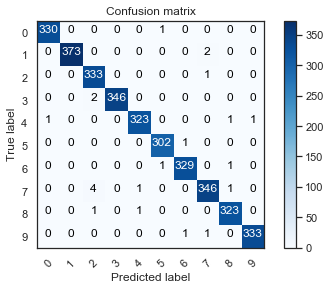

In [385]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

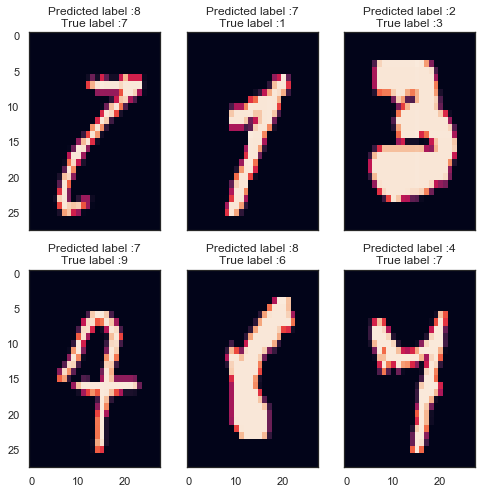

In [388]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(8, 8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), aspect='auto')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## Model Predictions on Test set
- Saving model output in .csv

In [439]:
predictions = model.predict(X_test)
results = np.argmax(predictions,axis = 1)
results = pd.Series(results,name="Label")

In [440]:
test_df = y_test.reset_index()

In [444]:
predict_df = pd.DataFrame(results.values, columns=['predictions'])

In [445]:
test_df['predict'] = predict_df['predictions']

In [446]:
test_df.rename(columns={'index': 'original_index'}, inplace=True)

In [438]:
test_df.to_csv('model_predict.csv', index=False)

## Model accuracy: `0.992`

In [499]:
# convert y_test to categorical... should've done it with X_test
y_test = to_categorical(y_test, num_classes = 10)

In [501]:
# this model is trained without data augmentation
accuracy = model.evaluate(X_test, y_test)[1]
print(f"Accuracy of the model is: {accuracy}")

263/263 [==============================] - 6s 22ms/step - loss: 0.0427 - accuracy: 0.9921
Accuracy of the model is: 0.9921428561210632


## Accuracy of the model with data augmentation is `0.967`

In [464]:
history.history['accuracy'][-1]

0.9668981432914734

In [495]:
y_test = to_categorical(y_test, num_classes = 10)